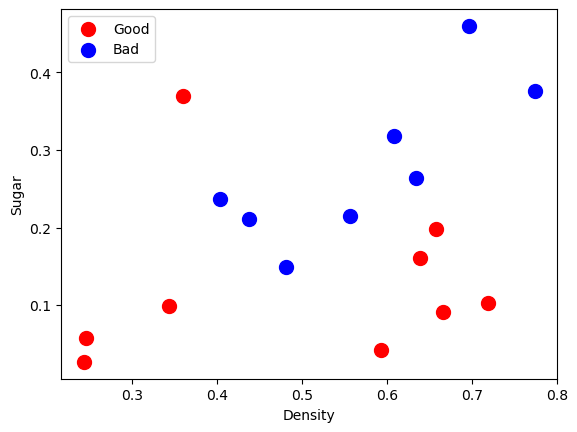

beta: [-1.7269114  11.53702475 -1.15743931]
accuracy_score: 0.8333333333333334


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.utils import shuffle

# 载入数据
dataset = np.loadtxt('../machine learning note/watermelon_3a.csv', delimiter=',')
X = dataset[:,1:3]
y = dataset[:,3]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

# 绘制散点图
plt.scatter(X[y==0][:,0],X[y==0][:,1],color='red',s=100,label='Good')
plt.scatter(X[y==1][:,0],X[y==1][:,1],color='blue',s=100,label='Bad')
plt.xlabel('Density')
plt.ylabel('Sugar')
plt.legend()
plt.show()
        
# Sigmoid函数
def sigmoid(X,beta):
    return 1.0 / (1+np.exp(-np.dot(X,beta)))

# 分布率
def likelihood_sub(X,y,beta):
    return -y * np.dot(beta,X.T) + np.log(1 + np.exp(np.dot(beta,X.T)))

# 似然函数
def likelihood(X,y,beta):
    num = len(y)
    sum = 0
    for i in range(num):
        sum += likelihood_sub(X[i],y[i],beta)
    return sum

# 梯度下降每一次参数更新，对应公式3.30
def gradient_step(alpha,X,y,beta):
    prediction  = sigmoid(X,beta)
    error = prediction - y
    gradientStep = alpha * np.dot(X.T,error)    
    beta -= gradientStep
    return beta

# 批量梯度下降
def gradient_descent(X,y,beta,alpha,num_iterations):   
    for i in range(num_iterations):
        beta = gradient_step(alpha,X,y,beta)
        loss = likelihood(X,y,beta)
        # print('Iteration:',i,'Loss:',loss)
    return beta,loss

# 随机梯度下降（每次只沿着一个方向下降）
def stochastic_gradient_descent(X, y, beta, alpha, num_epochs):
    sample_size = X.shape[0]
    for i in range(num_epochs):
        X, y = shuffle(X, y)  # 打乱数据顺序
        for j in range(sample_size):
            beta = gradient_step(alpha, X[j], y[j], beta)
        loss = likelihood(X, y, beta)
    return beta, loss

# 预测函数
def predict(X,beta):
    sample_size = X.shape[0]
    y = np.zeros(sample_size)
    for i in range(sample_size):
        if sigmoid(X[i],beta) > 0.5:
            y[i] = 1
        else:
            y[i] = 0
    return y

# 计算准确率
def accuracy(y_true,y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# 训练模型
feature_size = X_train.shape[1]
beta = np.zeros(feature_size + 1)
alpha = 0.1
num_iterations = 500
X_train = np.c_[X_train,np.ones((X_train.shape[0],1))]
X_test = np.c_[X_test,np.ones((X_test.shape[0],1))]
beta,loss = gradient_descent(X_train,y_train,beta,alpha,num_iterations)
print('beta:',beta)
predictions = predict(X_test,beta)
accuracy_score = accuracy(y_test,predictions)
print('accuracy_score:',accuracy_score)




    


模型参数: [-3.65153202 18.13566179 -1.22475842]
测试集准确率: 0.8333333333333334


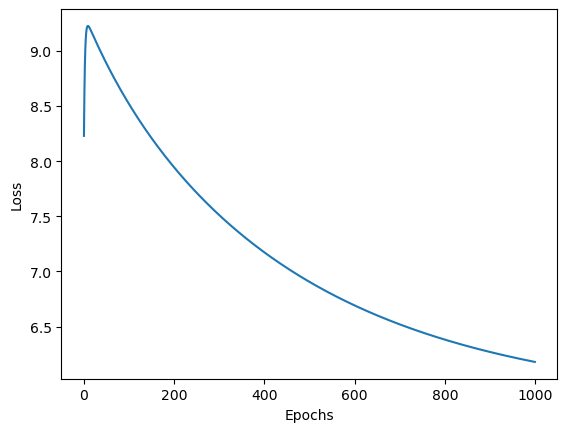

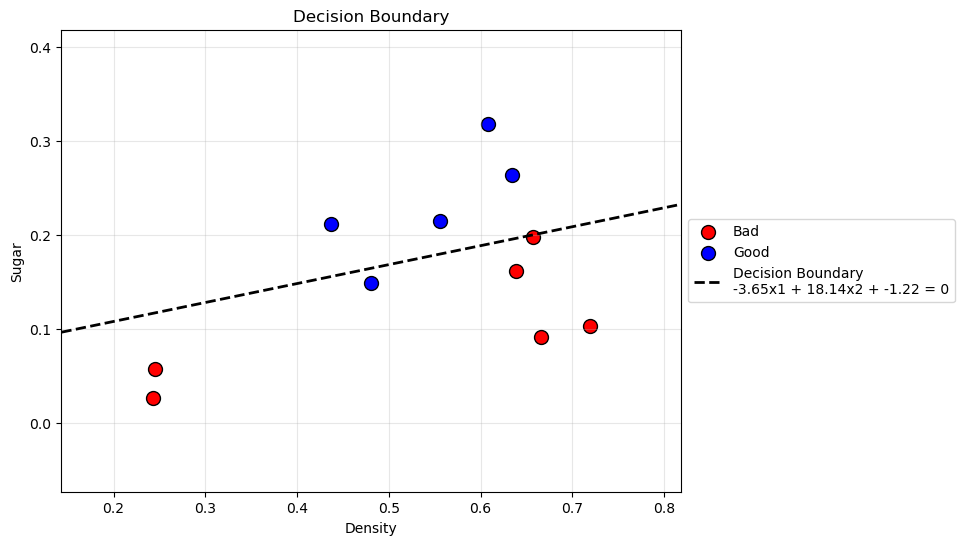

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

class LogisticRegression:
    def __init__(self,fit_intercept=True,method='batch',
                 learning_rate=0.1,max_iter=1000,random_state=None):
        """
        逻辑回归分类器
        
        参数:
        - fit_intercept: 是否添加偏置项 (默认True)
        - method: 优化方法 ['batch'(批量梯度下降), 'stochastic'(随机梯度下降)] (默认'batch')
        - learning_rate: 学习率 (默认0.1)
        - max_iter: 最大迭代次数 (默认500)
        - random_state: 随机种子 (默认None)
        """
        self.fit_intercept = fit_intercept
        self.method = method
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.beta = None
        self.loss_history = []

    def add_intercept(self,X):
        """设置偏置项(X,1)"""
        if self.fit_intercept:
            return np.c_[X,np.ones(X.shape[0])]
        else:
            return X
        
    def sigmoid(self,z):
        """sigmoid函数"""
        return 1.0 / (1.0 + np.exp(-z))
    
    def loss(self,X,y):
        """计算似然损失(3.27)"""
        z = X @ self.beta
        loss_terms = -y * z + np.log(1 + np.exp(-z))
        return np.sum(loss_terms)

    def batch_gradient_step(self,X,y):
        """批量梯度下降更新参数(3.30)""" 
        p = self.sigmoid(X @ self.beta)
        gradent = X.T @ (p - y)
        self.beta -= self.learning_rate * gradent

    def stochastic_gradient_step(self,X,y):
        """随机梯度下降更新参数(一次随机更新一个方向)"""
        for i in range(X.shape[0]):
             p = self.sigmoid(X[i] @ self.beta)
             gradent = X[i] * (p - y[i])
             self.beta -= self.learning_rate * gradent
        
    def fit(self,X,y):
        """
        训练模型
        
        参数:
        - X: 特征矩阵 (n_samples, n_features)
        - y: 标签向量 (n_samples,)
        """

        # 数据预处理(m个数据，n-1个特征)
        X = self.add_intercept(X)
        m,n = X.shape
        self.beta = np.zeros(n)

        # 设置随机种子
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # 选择优化方法
        if self.method == 'batch':
            optimizer = self.batch_gradient_step
        elif self.method =='stochastic':
            optimizer = self.stochastic_gradient_step
        else:
            raise ValueError("method must be 'batch' or'stochastic'")

        # 训练模型
        for epoch in range(self.max_iter):
            # 随机梯度下降每次迭代后随机打乱数据
            if self.method == 'stochastic':
                X,y = shuffle(X,y)

            # 执行一次梯度下降更新
            optimizer(X,y)

            # 记录损失
            self.loss_history.append(self.loss(X,y))

        return self
    
    def predict_proba(self,X):
        """返回预测概率"""
        X = self.add_intercept(X)
        return self.sigmoid(X @ self.beta)
    
    def predict(self,X):
        """返回预测类别"""
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def score(self,X,y):
        """计算准确率"""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def plot_loss_curve(self):
        """绘制损失变化图"""
        plt.plot(self.loss_history)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    def plot_decision_boundary(self,X,y):
        """绘制决策边界"""
        if X.shape[1] != 2:
            raise ValueError("只支持二维特征可视化!")
        # 提取模型参数
        w1, w2, b = self.beta[0], self.beta[1], self.beta[2]
        
        # 生成网格点坐标
        x_min, x_max = X[:,0].min()-0.1, X[:,0].max()+0.1
        y_min, y_max = X[:,1].min()-0.1, X[:,1].max()+0.1
        xx = np.linspace(x_min, x_max, 100)
        
        # 计算决策边界直线方程：w1*x1 + w2*x2 + b = 0 → x2 = (-w1*x1 -b)/w2
        decision_line = (-w1 * xx - b) / w2
        
        # 创建画布
        plt.figure(figsize=(8,6))
        
        # 绘制原始数据点
        plt.scatter(X[y==0][:,0], X[y==0][:,1], color='red', 
                    edgecolor='k', s=100, label='Bad')
        plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', 
                    edgecolor='k', s=100, label='Good')
        
        # 绘制决策边界
        plt.plot(xx, decision_line, 'k--', lw=2, 
                label=f'Decision Boundary\n{w1:.2f}x1 + {w2:.2f}x2 + {b:.2f} = 0')
        
        # 美化显示
        plt.xlabel("Density")
        plt.ylabel("Sugar")
        plt.title("Decision Boundary")
        plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.grid(alpha=0.3)
        plt.show()
        

if __name__ == '__main__':
    # 加载数据
    dataset = np.loadtxt('../machine learning note/watermelon_3a.csv', delimiter=',')
    X = dataset[:, 1:3]
    y = dataset[:, 3]

    # 划分数据集(0.3的测试集)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # 初始化模型(批量梯度下降)
    model = LogisticRegression(
        method='batch',       
        learning_rate=0.1,
        max_iter=1000,
        random_state=42
    )

    # 训练模型
    model.fit(X_train, y_train)

    # 评估模型
    print("模型参数:", model.beta)
    print("测试集准确率:", model.score(X_test, y_test))

    # 损失可视化
    model.plot_loss_curve()

    # 决策边界可视化
    model.plot_decision_boundary(X_train, y_train)

            
            









In [72]:
import numpy as np
import matplotlib.pyplot as plt

dataset = np.loadtxt('../machine learning note/watermelon_3a.csv',delimiter=',')
X = dataset[:,1:3]
y = dataset[:,3]


# 计算均值
mean1 = np.mean(X[y == 1],axis = 0)
mean0 = np.mean(X[y == 0],axis = 0)

print(mean1,mean0)

[0.57375 0.27875] [0.49611111 0.12752222]


d:\software\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\software\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


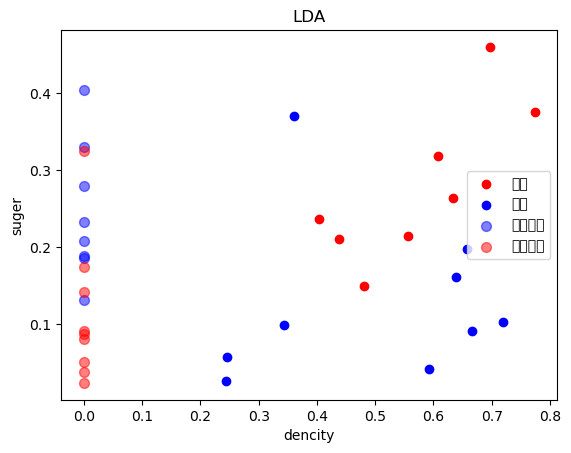

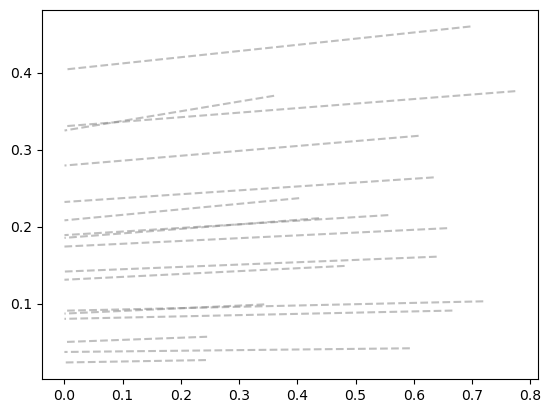

In [ ]:
# 计算类内散度矩阵Sw(公式3.33)
X0 = X[y == 0] - mean0
X1 = X[y == 1] - mean1
Sw = X0.T @ X0 + X1.T @ X1

# 计算LDA(公式3.39)
w = np.linalg.inv(Sw) @ (mean0 - mean1)

# 绘制数据集
plt.scatter(X[y == 1][:,0],X[y == 1][:,1],c='r',marker='o',label='正例')
plt.scatter(X[y == 0][:,0],X[y == 0][:,1],c='b',marker='o',label='反例')
plt.xlabel('dencity')
plt.ylabel('suger')
plt.title('LDA')

# 计算每个数据点在投影方向上的投影点(降维)
X_projected = X @ w

# 创建一个用于投影的二维数组
w_prime_2d = np.array([w[0], w[1]])
X_projected_points = X_projected[:, np.newaxis] * w_prime_2d

# 绘制投影点
plt.scatter(X_projected_points[y == 1][:, 0], X_projected_points[y == 1][:, 1], c='b', s=50, alpha=0.5, label='正例投影')
plt.scatter(X_projected_points[y == 0][:, 0], X_projected_points[y == 0][:, 1], c='r', s=50, alpha=0.5, label='反例投影')

# 绘制从数据点到投影点的线段
for i in range(len(X)):
    plt.plot([X[i][0], X_projected_points[i][0]], [X[i][1], X_projected_points[i][1]], color='gray', linestyle='--', alpha=0.5)

   



In [83]:
a = X[0]
a = np.map(a)
print(a.shape)

AttributeError: module 'numpy' has no attribute 'map'

FileNotFoundError: [Errno 2] No such file or directory: '../py_test/Data/watermelon3.0.csv'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import operator

class ID3:
    def __init__(self):
        self.tree = None

    def fit(self, X, y,features):
        """
        训练模型
        
        参数:
        - X: 特征矩阵 (n_samples, n_features)
        - y: 标签向量 (n_samples,)
        - features: 特征列表 (n_features,)
        """
        self.tree = self.createTree(X, y, features)

    def createTree(self, X, y, features):
        """
        创建决策树
        
        参数:
        - X: 特征矩阵 (n_samples, n_features)
        - y: 标签向量 (n_samples,)
        - features: 特征列表 (n_features,)
        
        返回:
        - 决策树
        """
        # 如果所有样本的标签相同，则返回该标签
        if len(set(y)) == 1:
            return y[0]
        
        # 如果没有特征，则返回出现次数最多的标签
        if len(X[0]) == 0:
            return self.majorityCnt(y)
        
        # 选择最优特征
        bestFeatureIndex,bestSplitValue = self.chooseBestFeature(X, y, features)
        bestFeatureLabel = features[bestFeatureIndex]

        # 创建节点
        tree = {bestFeatureLabel:{}}
        # 使用副本避免修改原始列表
        subfeatures = features.copy()
        # 连续特征
        if type(bestSplitValue).__name__ == 'float':
            tree[bestFeatureLabel]['<='+str(bestSplitValue)] = self.createTree(self.splitDataSetByValue(X, y, bestFeatureIndex, bestSplitValue, False)[0],
                                                                                    self.splitDataSetByValue(X, y, bestFeatureIndex, bestSplitValue, False)[1],
                                                                                    subfeatures)
            tree[bestFeatureLabel]['>'+str(bestSplitValue)] = self.createTree(self.splitDataSetByValue(X, y, bestFeatureIndex, bestSplitValue, True)[0],
                                                                                   self.splitDataSetByValue(X, y, bestFeatureIndex, bestSplitValue, True)[1],
                                                                                   subfeatures)
        # 离散特征
        else:
            # 删除当前特征
            del(subfeatures[bestFeatureIndex])
            # 遍历所有取值,开始递归
            for value in set(X[:,bestFeatureIndex]):
                tree[bestFeatureLabel][value] = self.createTree(self.splitDataSet(X, y, bestFeatureIndex, value)[0],
                                                                     self.splitDataSet(X, y, bestFeatureIndex, value)[1],
                                                                     subfeatures)
        return tree
    
    def majorityCnt(self, y):
        """返回最多的标签"""
        # 统计标签出现的次数
        lable_count = {}
        for lable in y:
            if lable not in lable_count:
                lable_count[lable] = 0
            lable_count[lable] += 1
        # 降序排序[(类标签,出现次数),(),()]
        sortedclassCount = sorted(lable_count.items(), key=operator.itemgetter(1), reverse=True)
        return sortedclassCount[0][0]
    
    def chooseBestFeature(self, X, y):
        """通过信息增益选择最优特征"""
        featureNum = len(X[0])
        bestInfoGain = 0.0
        bestSplitValue = 0
        bestFeatureIndex = -1
        baseEntropy = self.caculateEntropy(y)

        # 遍历所有特征
        for i in range(featureNum):
            # 提取当前特征下的取值
            featureValues = X[:, i]
            # 离散特征
            if isinstance(featureValues[0], str):
                uniqueValues = set(featureValues)
                currentEntropy = 0.0
                # 遍历所有取值
                for value in uniqueValues:
                    subX, subY = self.splitDataSet(X, i, value)
                    prob = len(subX) / len(X)
                    currentEntropy += prob * self.caculateEntropy(subY)
                # 计算信息增益
                inforGain = baseEntropy - currentEntropy
                if inforGain > bestInfoGain:
                    bestInfoGain = inforGain
                    bestFeatureIndex= i
                    bestSplitValue = None
            # 连续特征
            else:
                # 对特征值进行排序
                sortedFeatureValues = sorted(featureValues)
                # 计算分割值（取相邻两个取值的中点）
                splitList = []
                for i in range(len(sortedFeatureValues)-1):
                    splitList.append((sortedFeatureValues[i]+sortedFeatureValues[i+1]) / 2.0)
                # 遍历所有分割值,相当于做二分类
                for splitValue in splitList:
                    currentEntropy = 0.0
                    subX1, subY1 = self.splitDataSetByValue(X, y, i, splitValue, True)
                    subX2, subY2 = self.splitDataSetByValue(X, y, i, splitValue, False)
                    prob1 = len(subX1) / len(X)
                    prob2 = len(subX2) / len(X)
                    currentEntropy = prob1 * self.caculateEntropy(subY1) + \
                                     prob2 * self.caculateEntropy(subY2)
                    # 计算信息增益
                    inforGain = baseEntropy - currentEntropy
                    if inforGain > bestInfoGain:
                        bestInfoGain = inforGain
                        bestFeatureIndex= i
                        bestSplitValue = splitValue
        return bestFeatureIndex,bestSplitValue

    def caculateEntropy(self, y):
        """计算信息熵"""
        sample_num = len(y)
        # 统计标签出现的次数
        lable_count = {}
        for lable in y:
            if lable not in lable_count:
                lable_count[lable] = 0
            lable_count[lable] += 1
        
        # 计算信息熵
        entropy = 0.0
        for lable in lable_count:
            prob = lable_count[lable] / sample_num
            entropy -= prob * np.log2(prob)

        return entropy
    
    def splitDataSet(self,X,y,axis,value):
        '''
        根据特征索引i和离散特征值value将数据集切分

        参数:
        - X: 特征矩阵 (n_samples, n_features)
        - y: 标签向量 (n_samples,)
        - axis: 特征索引
        - value: 特征值

        返回:
        - 切分后的子集
        '''

        sub_X = []
        sub_y = []
        # 遍历每一行
        for i,featVec in enumerate(X):
            if featVec[axis] == value:
                reducedFeature = featVec[:axis]
                reducedFeature.extend(featVec[axis+1:])
                sub_X.append(reducedFeature)
                sub_y.append(y[i])
        return sub_X,sub_y
    
    def splitDataSetByValue(self,X,y,axis,value,isAbove):
        '''
        根据特征索引i和连续特征值value将数据集切分

        参数:
        - X: 特征矩阵 (n_samples, n_features)
        - y: 标签向量 (n_samples,)
        - axis: 特征索引
        - value: 特征值
        - isAbove: True表示大于value，False表示小于value

        返回:
        - 切分后的子集
        '''

        sub_X = []
        sub_y = []
        # 遍历每一行
        for i,featVec in enumerate(X):
            if isAbove and featVec[axis] > value:
                reducedFeature = featVec[:axis]
                reducedFeature.extend(featVec[axis+1:])
                sub_X.append(reducedFeature)
                sub_y.append(y[i])
            elif not isAbove and featVec[axis] <= value:
                reducedFeature = featVec[:axis]
                reducedFeature.extend(featVec[axis+1:])
                sub_X.append(reducedFeature)
                sub_y.append(y[i])
        return sub_X,sub_y
    
    def printTree(self,tree,indent=''):
        """打印决策树"""
        # 叶子节点
        if isinstance(tree,str) or isinstance(tree,int):
            print(tree)
        # 非叶子节点
        else:
            for key,value in tree.items():
                print(indent+str(key))
                self.printTree(value,indent+'\t')

if __name__ == '__main__':
   






    

[3]
